In [1]:
from sklearn.datasets import load_files
import numpy as np
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import gc

%matplotlib inline

#Data directories
train_directory = '../input/fruits/fruits-360_dataset/fruits-360/Training'
test_directory = '../input/fruits/fruits-360_dataset/fruits-360/Test'

Using TensorFlow backend.


In [2]:
# Load the data:
train_data = load_files(train_directory)
test_data = load_files(test_directory)

In [3]:
X_train = np.array(train_data['filenames'][:33000])
#convert file paths to image arrays:
X_train_img_array = []
for file in X_train:
    X_train_img_array.append(img_to_array(load_img(file)))
X_train = np.array(X_train_img_array)
del X_train_img_array


X_test = np.array(test_data['filenames'][:10000])
#convert file paths to image arrays:
X_test_img_array = []
for file in X_test:
    X_test_img_array.append(img_to_array(load_img(file)))
X_test = np.array(X_test_img_array)
del X_test_img_array


y_train = np.array(train_data['target'][:33000])
target_labels = np.array(train_data['target_names'])
y_test = np.array(test_data['target'][:10000])

num_labels = len(np.unique(y_train))

del train_data
del test_data

#images are 255 intensity, so normalize:
X_train = X_train/255
X_test = X_test/255

gc.collect()

print('Shape of training set: ', X_train.shape)
print('Shape of test set: ', X_test.shape)
print('Number of possible labels: ', num_labels)

Shape of training set:  (33000, 100, 100, 3)
Shape of test set:  (10000, 100, 100, 3)
Number of possible labels:  120


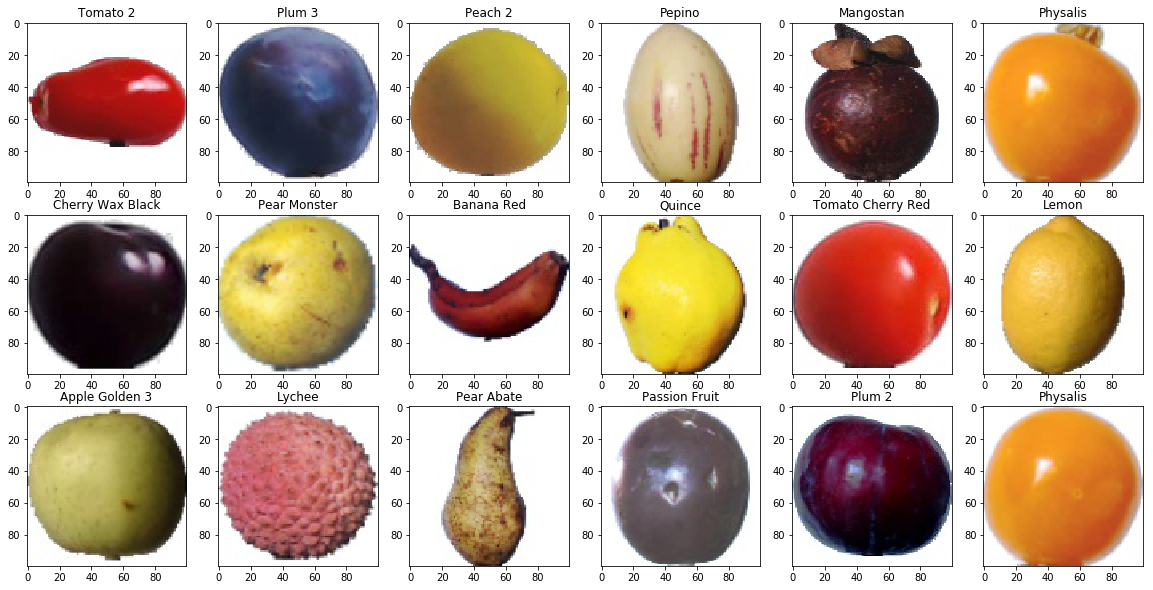

In [4]:
#Let's take a look at some of the images

fig1 = plt.figure(figsize = (20,10))
for i, idx in enumerate(np.random.choice(X_train.shape[0], size=18, replace=False)):
    subplt = fig1.add_subplot(3,6,i+1)
    subplt.imshow(X_train[idx])
    label_index = y_train[idx]
    subplt.set_title(target_labels[label_index])


In [5]:
#Look at target
y_train[:5]

array([ 1,  3, 51, 32, 13])

In [6]:
#Need to one-hot encode the target so it works with the CNN final output softmax:

y_train = np_utils.to_categorical(y_train, num_labels)
y_test = np_utils.to_categorical(y_test, num_labels)

y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [7]:
#CNN model building time:

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = 4, padding ='same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 4, padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))

# model.add(Conv2D(filters = 128, kernel_size = 4, padding ='same', activation = 'relu'))
# model.add(MaxPooling2D(pool_size = 2))
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      784       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)       

In [8]:
optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
#Split data into train and validation sets. With size of our data set, we can do ~20% validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0, test_size = 0.2)


In [10]:
#Fit the model

history = model.fit(X_train,y_train,
        batch_size = 64,
        epochs=30,
        validation_data=(X_val, y_val),
        verbose=1, shuffle=True)

Train on 26400 samples, validate on 6600 samples
Epoch 1/30
26400/26400 [==============================] - 20s 776us/step - loss: 2.7498 - accuracy: 0.3286 - val_loss: 0.5609 - val_accuracy: 0.8789
Epoch 2/30
26400/26400 [==============================] - 16s 618us/step - loss: 0.9853 - accuracy: 0.6929 - val_loss: 0.2315 - val_accuracy: 0.9450
Epoch 3/30
26400/26400 [==============================] - 16s 616us/step - loss: 0.6702 - accuracy: 0.7828 - val_loss: 0.1389 - val_accuracy: 0.9658
Epoch 4/30
26400/26400 [==============================] - 17s 633us/step - loss: 0.5254 - accuracy: 0.8263 - val_loss: 0.0759 - val_accuracy: 0.9805
Epoch 5/30
26400/26400 [==============================] - 16s 616us/step - loss: 0.4291 - accuracy: 0.8579 - val_loss: 0.0452 - val_accuracy: 0.9900
Epoch 6/30
26400/26400 [==============================] - 16s 618us/step - loss: 0.3649 - accuracy: 0.8784 - val_loss: 0.0320 - val_accuracy: 0.9911
Epoch 7/30
26400/26400 [==============================] -

In [11]:
#Calculate accurate on test set

score = model.evaluate(X_test, y_test, verbose=0)
print('Test % accuracy:', score[1]*100)

Test % accuracy: 96.11999988555908


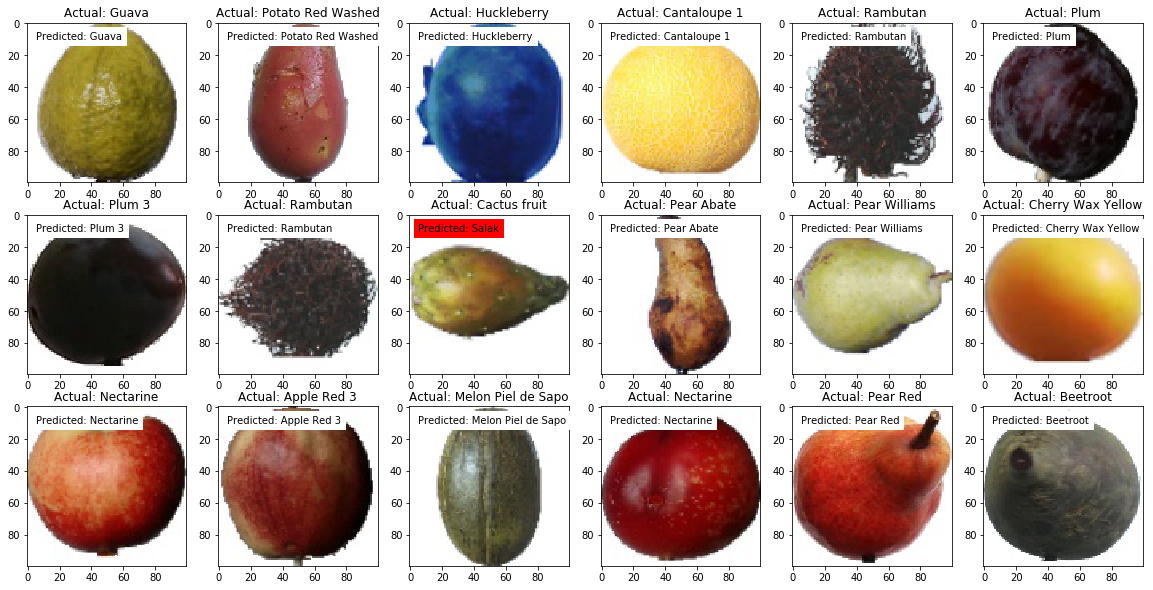

In [12]:
#Look at predictions for test images:

y_pred = model.predict(X_test)

fig2 = plt.figure(figsize=(20, 10))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=18, replace=False)):
    subplt = fig2.add_subplot(3, 6, i + 1)
    subplt.imshow(X_test[idx])
    pred_index = np.argmax(y_pred[idx])
    true_index = np.argmax(y_test[idx])
    subplt.set_title(f"Actual: {target_labels[true_index]}")
    subplt.text(5, 10, f"Predicted: {target_labels[pred_index]}", color='k', backgroundcolor=("white" if pred_index == true_index else "red"))

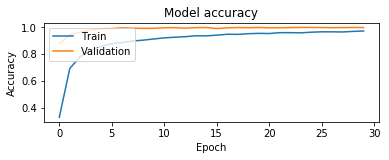

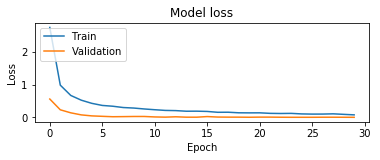

In [13]:
# From https://keras.io/visualization/

# Plot training & validation accuracy values
plt.subplot(2,1,1) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.subplot(2,1,2) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Size of test set:  10000
Total wrong:  388
% Wrong: 3.88


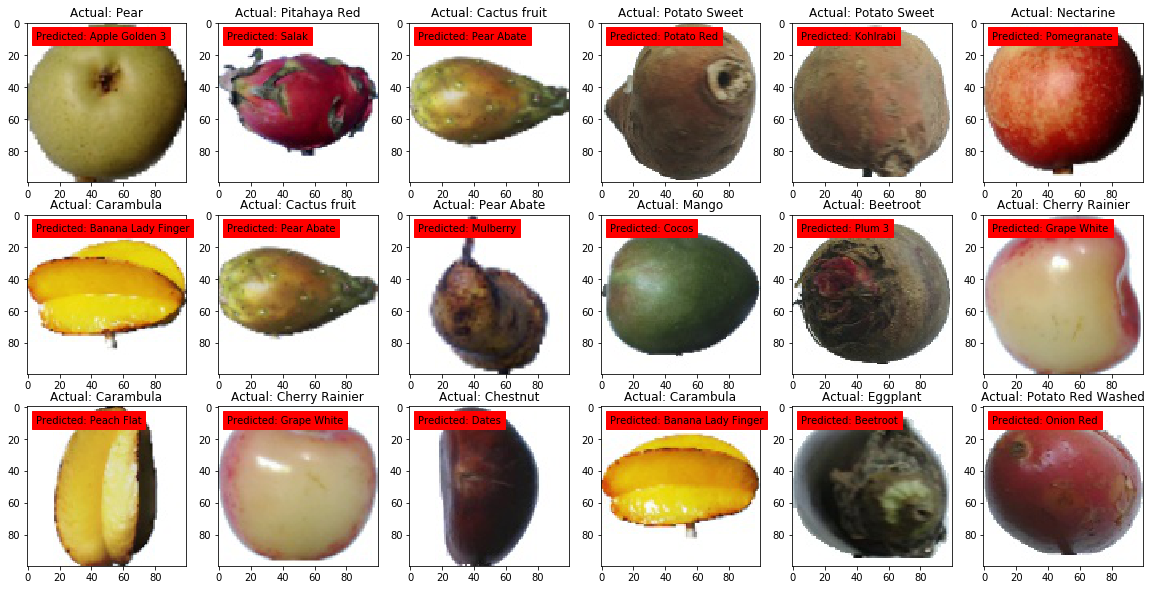

In [14]:
#Look at some examples of images we classified wrongly:

wrong_indices =[]
L = len(y_pred)
for i in range(L):
    if np.argmax(y_pred[i]) != np.argmax(y_test[i]):
        wrong_indices.append(i)

print("Size of test set: ", L)
print("Total wrong: ", len(wrong_indices))
print("% Wrong:", 100*len(wrong_indices)/L)
        
fig3 = plt.figure(figsize=(20, 10))
for i, idx in enumerate(np.random.choice(wrong_indices, size=18, replace=False)):
    subplt = fig3.add_subplot(3, 6, i + 1)
    subplt.imshow(X_test[idx])
    pred_index = np.argmax(y_pred[idx])
    true_index = np.argmax(y_test[idx])
    subplt.set_title(f"Actual: {target_labels[true_index]}")
    subplt.text(5, 10, f"Predicted: {target_labels[pred_index]}", color='k', backgroundcolor="red")


It looks like it is hard to classify bananas from the perspective that does not show their curvature, and round red foods, like apple/tomato/nectarine/etc.